# 属性图数据集的划分

## 属性图的定义

属性图: ***G = (V, E, X)***  

节点集: ***V***   是**n**个节点的集合

边集: ***E***  是**m**条边（连接）的集合

节点特征: ***X***， 其中<img src=".\img\1.png" alt="image-20250121103432903" style="zoom: 80%;" />

包含了所有节点的r维度特征

拓扑信息: ***A***，其中<img src=".\img\3.png" alt="3" style="zoom:80%;" />   是一个邻接矩阵，矩阵的值![2](.\img\2.png)代表边的权重

## 数据举例

In [1]:
import random
import numpy as np
import torch
from torch_geometric.data import Data

num_nodes = 2655  # 节点数
num_classes = 5  # 节点种类
num_edges = 43356  # 单向边的数量

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# 生成5个随机数来确定每种节点的数量
node_counts = torch.randint(1, num_nodes // num_classes, (num_classes,))
node_counts = node_counts.float() / node_counts.sum() * num_nodes
node_counts = node_counts.int()
# 确保节点总数为num_nodes
node_counts[-1] = num_nodes - node_counts[:-1].sum()

# 累加计算每种节点的起始索引
start_indices = torch.cumsum(torch.cat((torch.tensor([0]), node_counts[:-1])), dim=0)

# 生成节点类别
y = torch.cat([torch.full((count,), i, dtype=torch.long) for i, count in enumerate(node_counts)])

x = torch.randn(num_nodes, 128)  # 随机初始化节点特征
edge_attr = torch.ones(num_edges, 1, dtype=torch.float)  # 假设全是正边，边的标签全为1

# 生成所有可能的节点对
class_pairs = torch.combinations(torch.arange(num_classes), 2)

# 计算每种边的数量
num_edge_types = len(class_pairs)
edge_counts = torch.randint(1, num_edges // num_edge_types, (num_edge_types,))
edge_counts = edge_counts.float() / edge_counts.sum() * num_edges
edge_counts = edge_counts.int()
# 确保边总数不超过num_edges
edge_counts[-1] = num_edges - edge_counts[:-1].sum()
edge_counts = edge_counts * 2

# 根据节点类别生成边和边类型
edge_index = []
edge_type = []

for pair_id, (class_id1, class_id2) in enumerate(class_pairs):
    # 获取当前类别的节点索引
    class_nodes1 = start_indices[class_id1] + torch.arange(node_counts[class_id1])
    class_nodes2 = start_indices[class_id2] + torch.arange(node_counts[class_id2])
    num_class_nodes1 = class_nodes1.size(0)
    num_class_nodes2 = class_nodes2.size(0)

    # 生成边索引
    if num_class_nodes1 > 0 and num_class_nodes2 > 0:
        num_edges = min(num_class_nodes1 * num_class_nodes2, edge_counts[pair_id] // 2)
        edges = torch.cartesian_prod(class_nodes1, class_nodes2)
        selected_edges = edges[torch.randperm(edges.size(0))[:num_edges]]

        # 添加正向边
        edge_index.append(selected_edges.t())
        edge_type.append(torch.full((num_edges,), pair_id, dtype=torch.long))

        # 添加反向边
        edge_index.append(selected_edges.flip(1).t())
        edge_type.append(torch.full((num_edges,), pair_id, dtype=torch.long))

# 合并所有边索引和边类型
edge_index = torch.cat(edge_index, dim=1)
edge_type = torch.cat(edge_type)

# 创建图数据集
data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr)

# save data with torch.save
torch.save(data, './graph.pt')
print(data)

Data(x=[2655, 128], edge_index=[2, 86712], edge_attr=[43356, 1], y=[2655])


**生成数据解释**

```python
    Data(x=[2655, 128], edge_index=[2, 86712], edge_attr=[43356, 1], y=[2655])
```

这是一个图数据, 包含了2655个结点的特征x, 节点的类别y.  包含43356*2条边的索引edge_index, 一条边可以表示为[head, tail], 每条边的权重edge_attr, edge_attr大部分情况为0或1, 每条边的类型edge_type, 不同类型的边，它们的head或tail类型不同.

图可以是有向图，无向图. 最终构造的图是稀疏的

In [2]:
import matplotlib.pyplot as plt

def draw_curve(pos_edge, neg_edge=None):
    pos_x, pos_y = pos_edge
    neg_x, neg_y = neg_edge

    # 创建图形
    plt.figure(figsize=(8, 6))

    # 绘制正样本坐标，用 'o' 表示
    plt.scatter(pos_x, pos_y, marker='o', color='blue', label='Pos Samples')

    # 绘制负样本坐标，用 '-' 表示
    plt.scatter(neg_x, neg_y, marker='x', color='red', label='Neg Samples')

    # 添加图例
    plt.legend()

    # 添加标题和标签
    plt.title('Positive and Negative Samples')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    # 显示图形
    plt.grid(True)
    plt.show()

## 有偏训练

### 思路

获取整个图的全部正边(pos_edge)，然后把所有未知边(no_label_edge)当作负边(neg_edge)，随机选取和正边相同数量的负边

### 举例

**输入数据**， 8个节点，24条双向边，3种节点，3种边

```python
    Data(x=[8, 128], edge_index=[2, 24], edge_attr=[24, 1], y=[8], edge_type=[24])
```

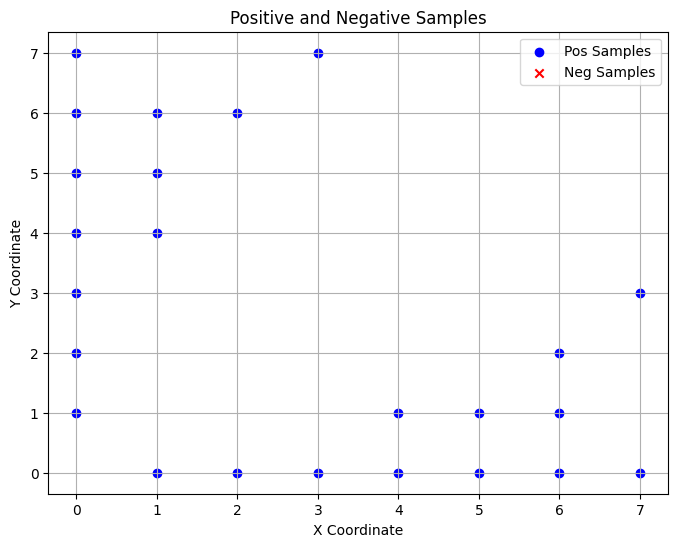

In [3]:
data = torch.load('./test.pt', weights_only=False)
draw_curve(data.edge_index, [[],[]])

**数据划分**

In [4]:
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import add_self_loops, negative_sampling

data = torch.load('./test.pt', weights_only=False)  # 数据太大不便于演示
edge_index = data.edge_index
valid_ratio = 0.1
test_ratio = 0.1
transform = RandomLinkSplit(num_val=valid_ratio, num_test=test_ratio, is_undirected=True, split_labels=True)
train_data, val_data, test_data = transform(data)
split_edge = {'biased_train': {}, 'valid': {}, 'test': {}, 'train': {}}

edge_index, _ = add_self_loops(edge_index, num_nodes=data.num_nodes)
train_pos_edge_index = torch.cat(
    (train_data.pos_edge_label_index, torch.flip(train_data.pos_edge_label_index, dims=[0])), dim=1)
# 负采样完全是随机的
train_neg_edge_index = negative_sampling(edge_index, num_nodes=train_data.num_nodes,
                                         num_neg_samples=train_data.edge_index.size(1))
split_edge['biased_train']['edge'] = train_pos_edge_index.t()
split_edge['biased_train']['edge_neg'] = train_neg_edge_index.t()

print(split_edge['biased_train']['edge'].t())  # (2, 20)
print(split_edge['biased_train']['edge_neg'].t())  # (2, 20)

tensor([[2, 0, 0, 1, 0, 0, 3, 0, 1, 0, 6, 7, 1, 6, 4, 2, 7, 5, 5, 3],
        [6, 7, 1, 6, 4, 2, 7, 5, 5, 3, 2, 0, 0, 1, 0, 0, 3, 0, 1, 0]])
tensor([[6, 5, 4, 3, 5, 2, 7, 6, 1, 1, 3, 6, 3, 4, 2, 3, 3, 7, 7, 7],
        [3, 7, 7, 6, 2, 4, 4, 5, 3, 7, 4, 7, 1, 6, 3, 5, 2, 1, 5, 2]])


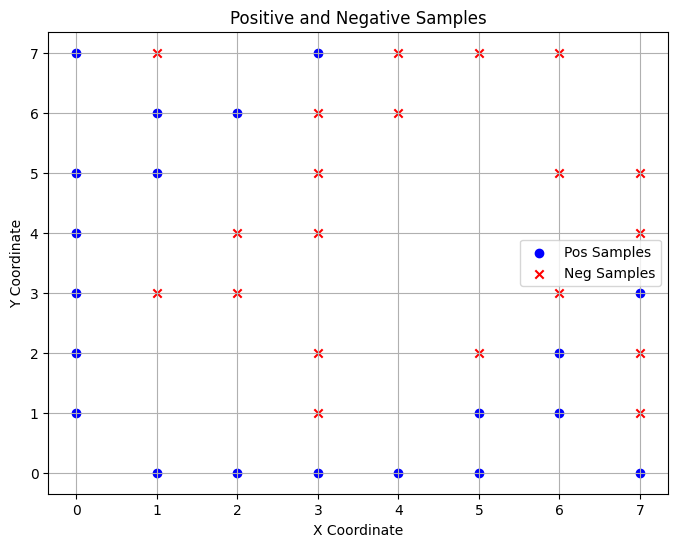

In [5]:
draw_curve(split_edge['biased_train']['edge'].t(), split_edge['biased_train']['edge_neg'].t())

## 无偏训练

### 思路

1. 设置随机种子，将原始图中的全部(正)边按比例划分为训练集，验证集，测试集<img src=".\img\8.png" alt="8" style="zoom: 67%;" />

2. 然后设置负边集

   - 训练集的负边：<img src=".\img\4.png" alt="4" style="zoom: 50%;" />
   - 验证集的负边：<img src=".\img\5.png" alt="5" style="zoom: 50%;" />
   - 测试集的负边：<img src=".\img\6.png" alt="6" style="zoom:50%;" />

   其中<img src=".\img\7.png" alt="7" style="zoom:50%;" /> 是原始图中全部的负边(包括自环self-loops)

### 举例

输入数据：8个节点，24条双向边，3种节点，3种边

```python
    Data(x=[8, 128], edge_index=[2, 24], edge_attr=[24, 1], y=[8], edge_type=[24])
```

In [6]:
split_edge['train']['edge'] = train_pos_edge_index.t()
train_edge_neg_mask = torch.ones((train_data.num_nodes, train_data.num_nodes), dtype=torch.bool)
train_edge_neg_mask[tuple(split_edge['train']['edge'].t().tolist())] = False
train_edge_neg_mask = torch.triu(train_edge_neg_mask, 1)
split_edge['train']['edge_neg'] = torch.nonzero(train_edge_neg_mask)

val_pos_edge_index = torch.cat(
    (val_data.pos_edge_label_index, torch.flip(val_data.pos_edge_label_index, dims=[0])), dim=1)
split_edge['valid']['edge'] = val_pos_edge_index.t()
valid_edge_neg_mask = train_edge_neg_mask.clone()
valid_edge_neg_mask[tuple(split_edge['valid']['edge'].t().tolist())] = False
split_edge['valid']['edge_neg'] = torch.nonzero(valid_edge_neg_mask)

test_pos_edge_index = torch.cat(
    (test_data.pos_edge_label_index, torch.flip(test_data.pos_edge_label_index, dims=[0])), dim=1)
split_edge['test']['edge'] = test_pos_edge_index.t()
test_edge_neg_mask = valid_edge_neg_mask.clone()
test_edge_neg_mask[tuple(split_edge['test']['edge'].t().tolist())] = False
split_edge['test']['edge_neg'] = torch.nonzero(test_edge_neg_mask)

In [7]:
print(split_edge['train']['edge'].t())  # (2, 20)
print(split_edge['train']['edge_neg'].t())  # (2, 18)

tensor([[2, 0, 0, 1, 0, 0, 3, 0, 1, 0, 6, 7, 1, 6, 4, 2, 7, 5, 5, 3],
        [6, 7, 1, 6, 4, 2, 7, 5, 5, 3, 2, 0, 0, 1, 0, 0, 3, 0, 1, 0]])
tensor([[0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6],
        [6, 2, 3, 4, 7, 3, 4, 5, 7, 4, 5, 6, 5, 6, 7, 6, 7, 7]])


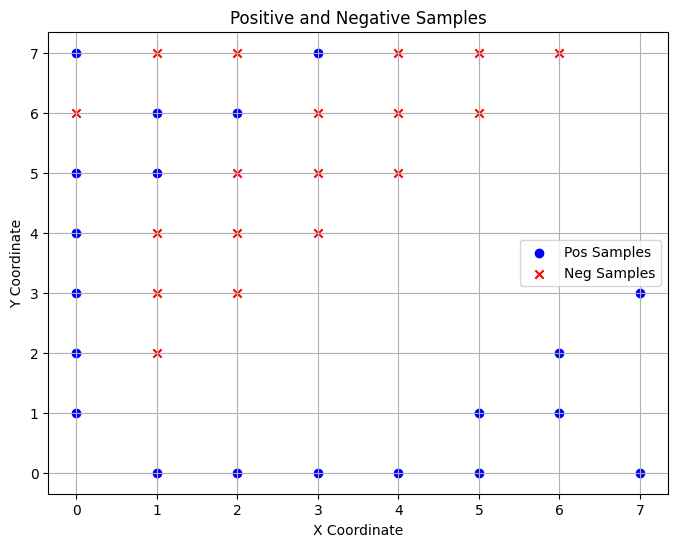

In [8]:
draw_curve(split_edge['train']['edge'].t(), split_edge['train']['edge_neg'].t())

In [9]:
print(split_edge['valid']['edge'].t())  # (2, 2)
print(split_edge['valid']['edge_neg'].t())  # (2, 17)

tensor([[0, 6],
        [6, 0]])
tensor([[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6],
        [2, 3, 4, 7, 3, 4, 5, 7, 4, 5, 6, 5, 6, 7, 6, 7, 7]])


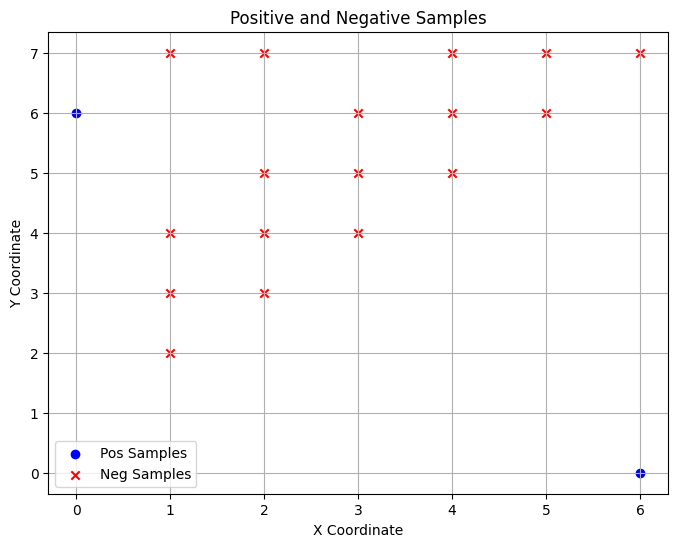

In [10]:
draw_curve(split_edge['valid']['edge'].t(), split_edge['valid']['edge_neg'].t())

In [11]:
print(split_edge['test']['edge'].t())  # (2, 2)
print(split_edge['test']['edge_neg'].t())  # (2, 16)

tensor([[1, 4],
        [4, 1]])
tensor([[1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 6],
        [2, 3, 7, 3, 4, 5, 7, 4, 5, 6, 5, 6, 7, 6, 7, 7]])


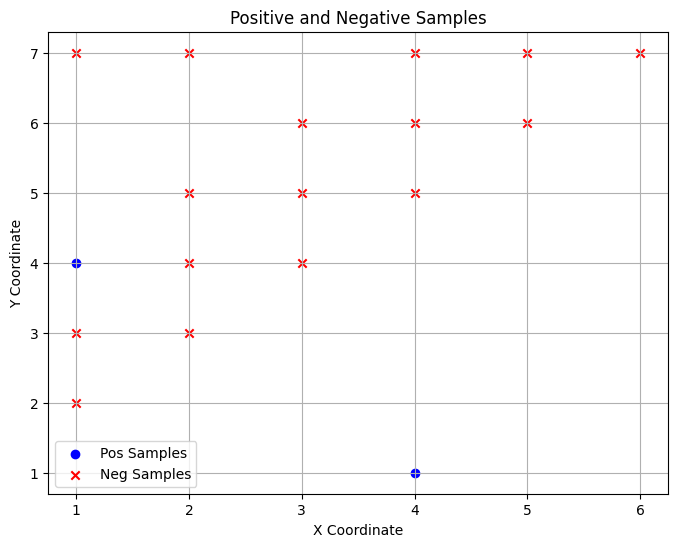

In [12]:
draw_curve(split_edge['test']['edge'].t(), split_edge['test']['edge_neg'].t())

## 评价指标

### Hits@k%

简述：计算在前 k 个最高预测分数的负样本中，正样本的预测分数是否高于这些负样本的分数

```python
    def hits_at_k(eval_true, eval_pred, k):
        pred_pos = eval_pred[eval_true == 1]
        pred_neg = eval_pred[eval_true == 0]
        kth_score_in_negative_edges = torch.topk(pred_neg, k)[0][-1]
        hitsk = float(torch.sum(pred_pos > kth_score_in_negative_edges).cpu()) / len(pred_pos)
        return hitsk
    hitsks = [hits_at_k(test_true, test_pred, k) for k in (25, 50, 100, 200, 400, 800, 1600, 3200, 6400)]
```

### Prec@k%

简述:计算在前 k %个预测结果中，真正正样本的比例

```python
    def precision_at_k(eval_true, eval_pred, k):
        eval_top_index = torch.topk(eval_pred, k, sorted=False).indices.cpu()
        eval_tp = eval_true[eval_top_index].sum().item()
        pk = eval_tp / k

        return pk

    pks = [precision_at_k(test_true, test_pred, k) for k in [ceil(num_test_edges * ratio) for ratio in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)]]
```

### AP%

简述:平均准确率

```
    ap = average_precision(test_true, test_pred)
```

# 划分数据集的作用

**训练集**：用于训练模型参数，梯度下降的

**验证集**：测试当前模型的效果，没有参与梯度下降。根据验证集上的结果调整超参数

**测试集**：只是在模型最终训练完成后，用来测试一下最后准确率

这三个数据集不能有交集，常见的比例是8:1:1，三个集合一般是同分布的

# 参考资料

[[2305.13656\] Link Prediction without Graph Neural Networks](https://arxiv.org/abs/2305.13656)  

[LPwithoutGNN](./book/Link_Prediction_without_Graph_Neural_Networks.pdf)

[训练集、验证集和测试集的意义 - 科学空间|Scientific Spaces](https://kexue.fm/archives/4638)